In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D

def clean_dataset(df):
  assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
  df.dropna(inplace=True)
  indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
  return df[indices_to_keep].astype(np.float64)

# Analisis descriptivo

In [138]:
df = pd.read_csv("C:/datos/trainml.csv")
df = clean_dataset(df)
df.TipoDoc=df.TipoDoc.apply(lambda x: "1" if x == 5 else "0").astype("category")
df.CodActvEconomica=df.CodActvEconomica.astype("category")
df.IdOcupacion =df.IdOcupacion.astype("category")
df.Patrimonio =df.Patrimonio.div(1000) #x10^3 (1K)
df.Utilidad =df.Utilidad.div(1000) #x10^3 (1K)
df.index = df.Identificacion
#TODO convertir edad y genero de la cedula según registraduria
df = df.loc[:,['TipoDoc', 'CodActvEconomica', 'IdOcupacion', 'Patrimonio', 'Utilidad']]
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8500 entries, 29384484.0 to 75180897.0
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   TipoDoc           8500 non-null   category
 1   CodActvEconomica  8500 non-null   category
 2   IdOcupacion       8500 non-null   category
 3   Patrimonio        8500 non-null   float64 
 4   Utilidad          8500 non-null   float64 
dtypes: category(3), float64(2)
memory usage: 245.5 KB


,Patrimonio,Utilidad
count,8.500000e+03,8500.000000
mean,2.480248e+06,149590.943432
std,1.447110e+06,86834.603636
min,3.624670e+02,90.701000
25%,1.210539e+06,74153.157250
50%,2.478655e+06,149992.896000
75%,3.721851e+06,224631.324000
max,4.999368e+06,299964.299000


In [ ]:
df.head(10)

# Analisis Exploratorio

## Analisis de CodActvEconomica

In [140]:
len(df.CodActvEconomica.unique())

330

In [132]:

arr = np.array(df.CodActvEconomica.unique())
ind_pos = [0,1,2]
arr[ind_pos]
arr

array([  10.,   90., 3012., 3099., 7910., 7730., 7710., 9521., 6513.,
       8550., 2393., 5210., 4322., 2610., 4661., 4512., 5310., 6494.,
       8423., 2814., 9609., 2229., 1392., 8522., 9004., 2910., 9491.,
       4775., 2310., 2651., 9700.,  142., 8421., 6312., 3510., 6200.,
       2021., 2395., 4690., 1020., 6910., 2221.,  721., 3091., 4711.,
       8620., 1393., 8699., 6521., 8692., 1702., 8890., 6491., 5914.,
       3120., 2660., 1701., 2731., 3820., 4923., 4911., 4789., 9312.,
       8220., 4390., 8523., 2421.,  129., 1420.,  113., 4652., 6619.,
       8551., 3700., 3092.,  110., 7830., 1061., 5610., 1820., 4663.,
       5511.,  990., 1083.,  144., 1399., 7210., 4753., 5812., 8420.,
       8552., 5513., 1312.,  729., 4912., 6120., 4782., 8621., 5911.,
       4660., 7410., 6422.,  143., 1084., 6499., 4662., 8510., 9200.,
       6520., 3600., 1062., 3512., 6390., 4665., 2410., 7020., 6493.,
       6020., 1512.,  161., 1101., 9420., 6532., 2680., 5912., 2012.,
       3810., 1051.,

<AxesSubplot:xlabel='CodActvEconomica', ylabel='Patrimonio'>

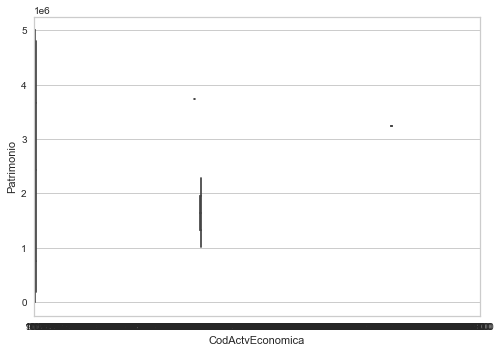

In [129]:

sb.boxplot(x="CodActvEconomica", y="Patrimonio", data=df.loc[df['CodActvEconomica'].isin(arr[0:5])])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\si

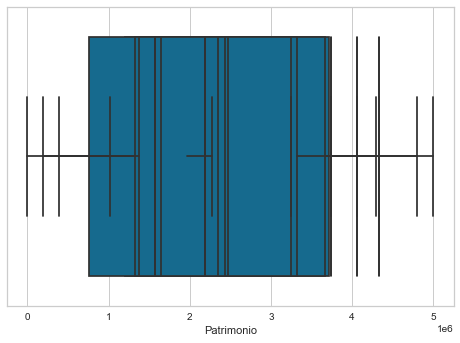

In [131]:
for val in df.CodActvEconomica.unique()[0:10]:
    sb.boxplot((df.where(df['CodActvEconomica']==val)).Patrimonio)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Patrimonio'>

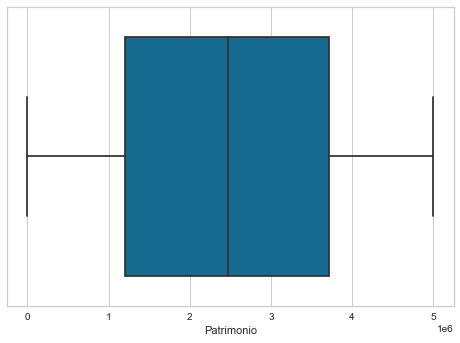

In [141]:
sb.boxplot((df.where(df['CodActvEconomica']==10)).Patrimonio)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Patrimonio'>

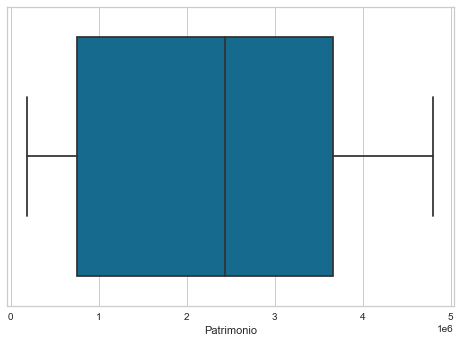

In [142]:
sb.boxplot((df.where(df['CodActvEconomica']==90)).Patrimonio)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Patrimonio'>

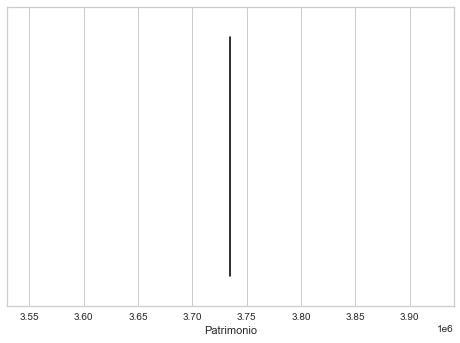

In [143]:
sb.boxplot((df.where(df['CodActvEconomica']==3012)).Patrimonio)

# Segmentacion con Arbol de decision

In [177]:
dfAD= df[df.TipoDoc == '1']
dfAD


,TipoDoc,CodActvEconomica,IdOcupacion,Patrimonio,Utilidad
Identificacion,,,,,


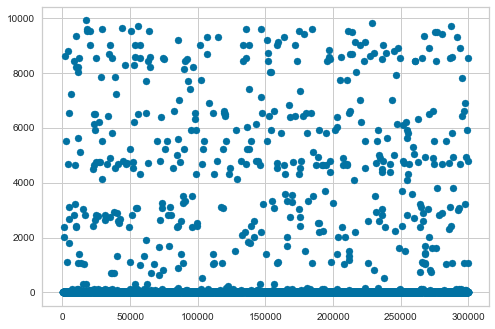

In [184]:
pyplot.scatter(df["Utilidad"],df["CodActvEconomica"])

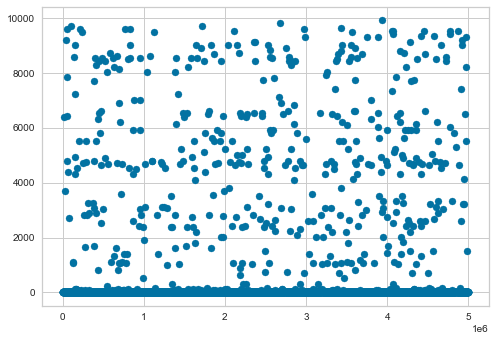

In [185]:
pyplot.scatter(df.Patrimonio,df["CodActvEconomica"])

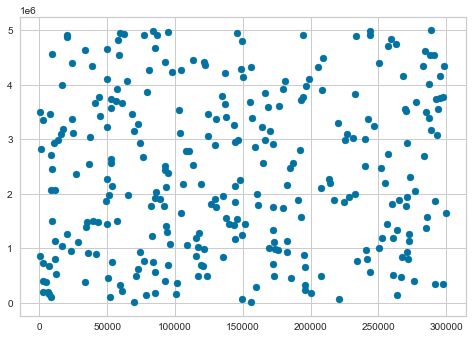

In [187]:
pyplot.scatter(df.head(300).Utilidad,df.head(300).Patrimonio)

In [209]:
df["NEW_VAR"] = np.where(df.Patrimonio<df.Utilidad , 1, 0)
y_train = df['NEW_VAR'].astype("int")
x_train = df.loc[:,['Patrimonio', 'Utilidad']]

In [210]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import Image as PImage

decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4) #,class_weight={1:3.5}
tree = decision_tree.fit(x_train, y_train)
confusion_matrix(y_train, tree.predict(x_train))

array([[8256,    2],
       [  27,  215]], dtype=int64)

In [212]:
from sklearn.metrics import classification_report
print(classification_report(y_train,tree.predict(x_train),labels=[1,0]))

              precision    recall  f1-score   support

           1       0.99      0.89      0.94       242
           0       1.00      1.00      1.00      8258

    accuracy                           1.00      8500
   macro avg       0.99      0.94      0.97      8500
weighted avg       1.00      1.00      1.00      8500



Feature: 0, Score: 0.86506
Feature: 1, Score: 0.13494


<BarContainer object of 2 artists>

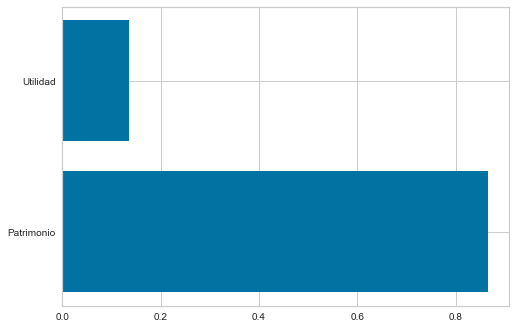

In [214]:
from matplotlib import pyplot
importance = tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

plt.barh(x_train.columns, tree.feature_importances_)

# Segmentacion con RF

# Segmentacion con XGBoost

# Segmentacion MCA con K-means

In [149]:

import mca
import prince
mcadf = prince.MCA()
mcadf = mca.fit(df) # same as calling ca.fs_r(1)
mcadf = mca.transform(df) # same as calling ca.fs_r_sup(df_new) for *another* test set.
mcadf
#mca_df = mca.MCA(df)

AttributeError: module 'mca' has no attribute 'fit'

In [150]:
ax = mca.plot_coordinates(
     X=df,
     ax=None,
     figsize=(6, 6),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1
     )

AttributeError: module 'mca' has no attribute 'plot_coordinates'

In [34]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
for i in range(2,8):
  '''
  Create KMeans instance for different number of clusters
  '''
  km = KMeans(n_clusters=i,max_iter=5, random_state=42).fit(df)
  score = silhouette_score(df, km.labels_, metric='euclidean')

# Print the score
  print('Silhouetter Score: %.3f' % i ,score)

Silhouetter Score: 2.000 0.6371938503569459
Silhouetter Score: 3.000 0.5658679881582075
Silhouetter Score: 4.000 0.5634309748772336
Silhouetter Score: 5.000 0.5337363359571944
Silhouetter Score: 6.000 0.5218348836563332
Silhouetter Score: 7.000 0.5100768718543072


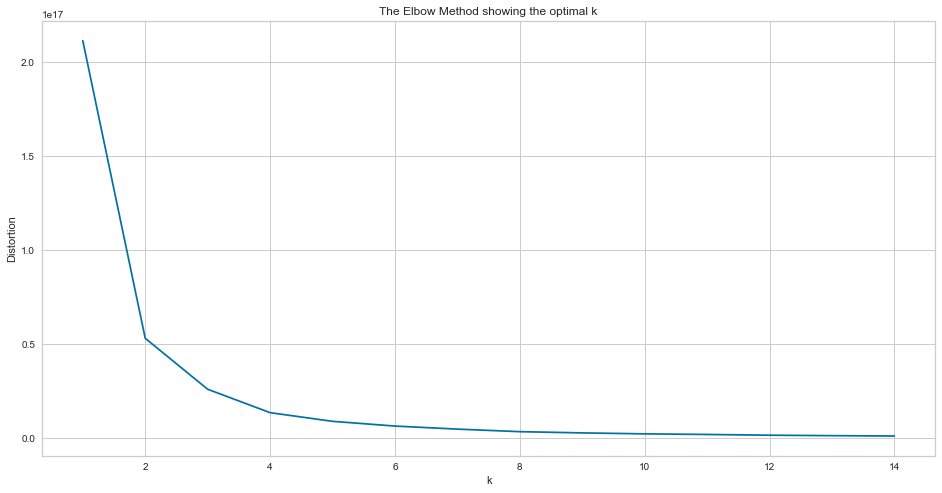

In [35]:
## Metodologia Elbow
distortions = []
K = range(1,15)
for k in K:
  kmeanModel = KMeans(n_clusters=k)
  kmeanModel.fit(df.iloc[:,[0,1]])
  distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# para variables numericas PCA, ACM para categoricas

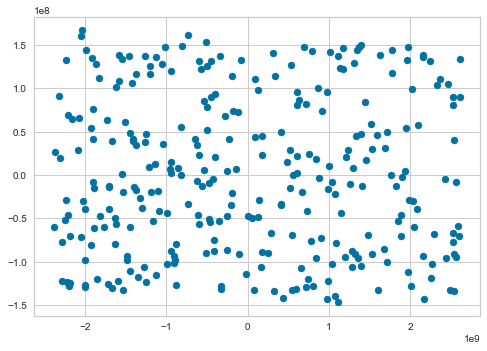

In [36]:

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(df)
INDIVID = pd.DataFrame(principalComponents)

f1 = INDIVID.iloc[:,0].values
f2 = INDIVID.iloc[:,1].values
plt.scatter(f1, f2, s=50, cmap='viridis')

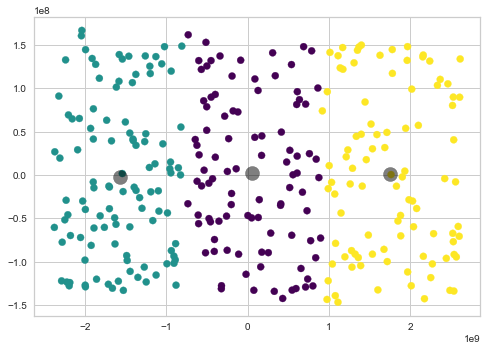

In [37]:
f1 = INDIVID.iloc[:,0].values
f2 = INDIVID.iloc[:,1].values
kmeans = KMeans(n_clusters=3).fit(INDIVID)
y_kmeans = kmeans.predict(INDIVID)
centroids = kmeans.cluster_centers_
plt.scatter(f1, f2, c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [38]:
score = silhouette_score(INDIVID, kmeans.labels_, metric='euclidean')
score

0.5658679881582075

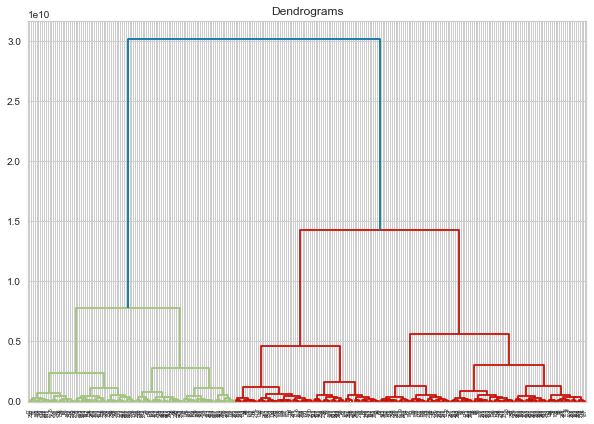

In [39]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df, method='ward'))

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward').fit_predict(df)
score = silhouette_score(df, cluster, metric='euclidean')

In [40]:
score

0.5492978926635586